RatU_Day2NSD_2021-07-24_08-16-38
All PBEs were imported..


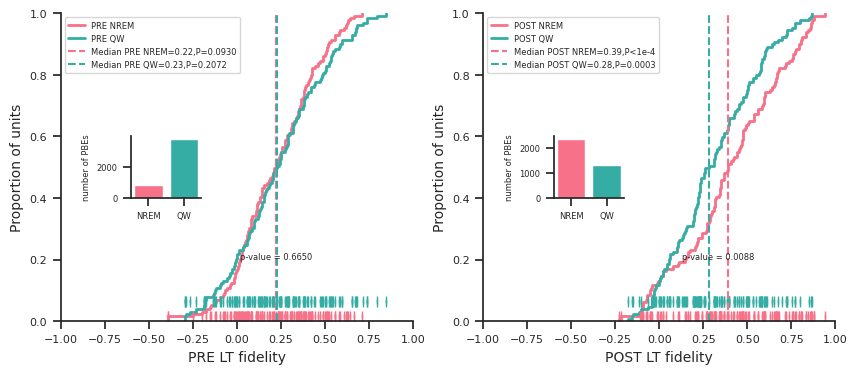

In [1]:
import os
import scipy.io
from scipy.stats import ranksums
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from learned_tuning.learned_tuning import calculate_learned_tuning, calculate_place_field_fidelity_of_learned_tuning


data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# included_session_IDX = [x for x in range(17) if x not in (9, 10)]
included_session_IDX = [8]

sessions = [sessions[i] for i in included_session_IDX]

for session_name in sessions:

    print(session_name)

    session_dataset_path = os.path.join(data_dir, session_name)


    #--------------------------------------------------------------------------------------------
    # Load epochs information

    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]
   


     #----------------------------------------------------------------------------------------------
    # Load spike data

    filename = f'{session_name}.spikes_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    spikes_pyr = mat_file["spikes_pyr"]

    #### Extracting all place fields from the imported .mat file
    spatial_tuning_smoothed = spikes_pyr["spatialTuning_smoothed"]

    num_units    = spatial_tuning_smoothed[0].shape[0]
    # num_units    = spatial_tuning_smoothed.shape[0] # for RatN only

    num_pos_bins = spatial_tuning_smoothed[0][0]['uni'][0][0].size

    # print(num_units, num_pos_bins)

    spikes = []; # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units):
        
        # Create dictionaries for each unit and store the matrices
        
        unit_spikes = dict()
        
        unit_spikes['place_fields']  = {}
        unit_spikes['peak_pos_bins'] = {}

        
        for direction in running_directions:
            try:
                unit_spikes['place_fields'][direction] = spatial_tuning_smoothed[0][unit][direction][0][0].reshape(num_pos_bins) 
                unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]

                # unit_spikes['place_fields'][direction] = spatial_tuning_smoothed[unit][0][direction][0][0].reshape(num_pos_bins) 
                # unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1


        unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
        unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0]
        unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]

        # unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] # for RatN and RatS
        # unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]
        # unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]
        
            
        spikes.append(unit_spikes) 

    # place fields by pooling spikes across both running directions
    place_fields_uni = []
    for unit in range(num_units):
        place_fields_uni.append(spikes[unit]['place_fields']['uni'])
    place_fields_uni = np.array(place_fields_uni)

    place_fields_uni[place_fields_uni == 0] = 1e-4




    # --------------------------------------------------------------------------------------------
    # Load cluster quality data (L-ratios)
    
    filename = f'{session_name}.clusterQuality.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)

    # Access data structure
    num_shanks = len(mat_file["clusterQuality"]["Lratio"][0])

    L_ratios = list()
    for shank in range(num_shanks):    
        curr_shank_L_ratios = dict()
        curr_shank_L_ratios["L_ratios"] = mat_file["clusterQuality"]["Lratio"][0][shank]
        curr_shank_L_ratios["cluster_ids"] = mat_file["clusterQuality"]["clus"][0][shank]
        
        L_ratios.append(curr_shank_L_ratios)
    # L_ratios = []


    #-------------------------------------------------------------------------------------------------
    # Population Burst Events (PBEs)

    filename = f'{session_name}.PBEInfo_replayScores.mat'
    # filename = f'{session_name}.PBEInfo.mat'


    file_path = os.path.join(session_dataset_path, filename)
    f = h5py.File(file_path, "r")

    PBEInfo = f['PBEInfo_replayScores']
    # PBEInfo = f['PBEInfo_Bayesian']



    # Store the population burst events in an object easy to work with in Python 
    PBEs = []
    num_PBEs = PBEInfo["fr_1msbin"].shape[0]
    attributes = list(PBEInfo.keys())

    # Loop over the PBEs and create a dictionary for each one
    num_dots = int(num_PBEs * (10/100))

    count = 0
    for pbe in range(num_PBEs): #   
        # Create a dictionary for the PBE and store the matrices
        PBE_dict = {}
        for attr in attributes:
            ref = PBEInfo[attr][pbe][0]
            obj = f[ref] 
            PBE_dict[attr] = np.array(obj) 

        PBEs.append(PBE_dict)

        if (pbe+1) % num_dots == 1:
            count += 1
            message = "Importing PBEs" + "." * count
            print(message, end="\r")

    print("All PBEs were imported")


    #----------------------------------------------------------------------------------------------------
    # Import results of learned tuning calculation in MALAB

    # Load .mat file
    filename = f'{session_name}.assemblyTunings_allPBEs_Lthresh1e_3.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)

    active_units = dict()

    active_units["pre"] = mat_file["activeUnits"]["pre"][0][0]
    active_units["maze"] = mat_file["activeUnits"]["run"][0][0]
    active_units["post"] = mat_file["activeUnits"]["post"][0][0]

    active_units_epochs_intersect = np.intersect1d(np.intersect1d(active_units["pre"], active_units["post"]), active_units["maze"])
    active_units_epochs_intersect = active_units_epochs_intersect - 1 # to make the indices compatible with the python indexing


    #------------------------------------------------------------------------------------------------------
    # Learned tunings during Non-REM versus Quiet Wake ripples


    # The frequency of PBEs ocurring during NREM ('N') or quiet wake ('W')

    num_PBEs = len(PBEs)
    PBEs_peak_time = np.zeros((num_PBEs, 1))
    brain_state_first_letter = np.empty((num_PBEs, 1), dtype='str')

    for pbe in range(num_PBEs):
        PBEs_peak_time[pbe] = PBEs[pbe]["peakT"]
        brain_state_first_letter[pbe]= chr(np.concatenate(PBEs[pbe]["brainState"])[0])


    # Calculate learned tunings separately for NREM and QW PBEs and calculate thier PF fidleities
    time_bin_duration=0.02
    num_PF_shuffles = 10000
    learned_tunings_NREM_vs_QW = {}  # create an empty dictionary to store the results

    for epoch in ['PRE', 'POST']:
        if epoch == 'PRE':
            epoch_idx = 0
            epoch_duration = epochs[0,1] - epochs[0,0]
        elif epoch == 'POST':
            epoch_idx = 2
            epoch_duration = 4*60*60
            
        # PBEs for the current epoch
        
        if_inside_epoch = (PBEs_peak_time >= epochs[epoch_idx,0]) & (PBEs_peak_time <= epochs[epoch_idx,0]+epoch_duration)

        # NREM PBEs
        select_IDX = np.where(np.logical_and(if_inside_epoch, brain_state_first_letter == 'N'))[0]
        epoch_NREM_PBEs = np.take(PBEs, select_IDX)
        num_PBEs_NREM = len(epoch_NREM_PBEs)

        # QW PBEs
        select_IDX = np.where(np.logical_and(if_inside_epoch, brain_state_first_letter == 'Q'))[0]
        epoch_QW_PBEs = np.take(PBEs, select_IDX)
        num_PBEs_QW = len(epoch_QW_PBEs)

        # learned tunings
        
        # NREM
        learned_tunings_NREM = calculate_learned_tuning(epoch_NREM_PBEs, spikes, L_ratios, time_bin_duration)
        
        learned_tuning_place_field_pearson_corr_NREM = np.full((num_units,), np.nan)
        learned_tuning_place_field_pearson_corr_NREM, median_LT_PF_pearson_corr_NREM = calculate_place_field_fidelity_of_learned_tuning(learned_tunings_NREM[active_units_epochs_intersect, :], place_fields_uni[active_units_epochs_intersect, :], num_PF_shuffles)
        
        # QW
        learned_tunings_QW = calculate_learned_tuning(epoch_QW_PBEs, spikes, L_ratios, time_bin_duration)

        learned_tuning_place_field_pearson_corr_QW = np.full((num_units,), np.nan)
        learned_tuning_place_field_pearson_corr_QW, median_LT_PF_pearson_corr_QW = calculate_place_field_fidelity_of_learned_tuning(learned_tunings_QW[active_units_epochs_intersect, :], place_fields_uni[active_units_epochs_intersect, :], num_PF_shuffles)
        
        # store the results in the dictionary
        learned_tunings_NREM_vs_QW[epoch] = {
            'learned_tunings_NREM': learned_tunings_NREM,
            'learned_tuning_place_field_pearson_corr_NREM': learned_tuning_place_field_pearson_corr_NREM,
            'median_LT_PF_pearson_corr_NREM': median_LT_PF_pearson_corr_NREM,
            'number_of_PBEs_NREM':num_PBEs_NREM,
            'learned_tunings_QW': learned_tunings_QW,
            'learned_tuning_place_field_pearson_corr_QW': learned_tuning_place_field_pearson_corr_QW,
            'median_LT_PF_pearson_corr_QW': median_LT_PF_pearson_corr_QW,
            'number_of_PBEs_QW':num_PBEs_QW
        }

    filename = f'{session_name}.learned_tunings_NREM_vs_QW.npy'
    file_path = os.path.join(session_dataset_path, filename)
    np.save(file_path, learned_tunings_NREM_vs_QW)
                                                                                                                                                                                                                                                                                                                                                   


    # Plot the distributions of learned tunings for NREM and QW periods within each epoch
    
    colors = sns.color_palette("husl", 2) # Set color palette
    sns.set_style('whitegrid') # Set style and context
    sns.set_context('paper')

    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)

    fig, axes = plt.subplots(1,2, figsize = (10, 4))

    for i, curr_epoch in enumerate(['PRE', 'POST']):

        learned_tuning_place_field_pearson_corr_NREM = learned_tunings_NREM_vs_QW[curr_epoch]['learned_tuning_place_field_pearson_corr_NREM']
        median_LT_PF_pearson_corr_NREM_pvalue = learned_tunings_NREM_vs_QW[curr_epoch]['median_LT_PF_pearson_corr_NREM']['p_value']
        
        learned_tuning_place_field_pearson_corr_QW = learned_tunings_NREM_vs_QW[curr_epoch]['learned_tuning_place_field_pearson_corr_QW']
        median_LT_PF_pearson_corr_QW_pvalue = learned_tunings_NREM_vs_QW[curr_epoch]['median_LT_PF_pearson_corr_QW']['p_value']

        num_PBEs_NREM = learned_tunings_NREM_vs_QW[curr_epoch]['number_of_PBEs_NREM']
        num_PBEs_QW = learned_tunings_NREM_vs_QW[curr_epoch]['number_of_PBEs_QW']


        # Plot the distributions using ECDFs with overlaid ticks
        sns.ecdfplot(learned_tuning_place_field_pearson_corr_NREM, ax = axes[i], label=f'{curr_epoch} NREM', color=colors[0], linewidth = 2)
        sns.ecdfplot(learned_tuning_place_field_pearson_corr_QW, ax = axes[i], label=f'{curr_epoch} QW', color=colors[1], linewidth = 2)
        axes[i].set_xlim([-1,1])
        axes[i].set_xlabel(f'{curr_epoch} LT fidelity', fontsize=10)
        axes[i].set_ylabel('Proportion of units', fontsize=10)
        axes[i].tick_params(labelsize=8)
        axes[i].legend(fontsize=8)


        # Add ticks to the x-axis
        y_min, y_max = axes[i].get_ylim()
        for x in learned_tuning_place_field_pearson_corr_NREM:
            axes[i].plot([x, x], [y_min+0.01, y_min + 0.02], '|-', color=colors[0], linewidth=0.25)
        for x in learned_tuning_place_field_pearson_corr_QW:
            axes[i].plot([x, x], [y_min+0.06, y_min + 0.07], '|-', color=colors[1], linewidth=0.25)

        # Calculate and display medians
        median_nrem = np.nanmedian(learned_tuning_place_field_pearson_corr_NREM)
        median_qw = np.nanmedian(learned_tuning_place_field_pearson_corr_QW)


        def get_pval_statement(pvalue):
            if pvalue < 0.0001:
                pvalue_statement = 'P<1e-4'
            else:
                pvalue_statement = f'P={pvalue:.4f}'
            return pvalue_statement


        axes[i].axvline(median_nrem, color=colors[0], linestyle='dashed', label=f'Median {curr_epoch} NREM={median_nrem:.2f},{get_pval_statement(median_LT_PF_pearson_corr_NREM_pvalue)}')
        axes[i].axvline(median_qw, color=colors[1], linestyle='dashed', label=f'Median {curr_epoch} QW={median_qw:.2f},{get_pval_statement(median_LT_PF_pearson_corr_QW_pvalue)}')
        axes[i].legend(fontsize=6)

        # Perform rank-sum test
        statistic, p_value = ranksums(learned_tuning_place_field_pearson_corr_NREM,
                                    learned_tuning_place_field_pearson_corr_QW)

        # Add line with p-value above the plot
        axes[i].text((median_nrem + median_qw) / 2, 0.2, f'p-value = {p_value:.4f}', ha='center', fontsize=6)

        

        # Bar plot of frequency of ripples in each brain states
        ax_inset = axes[i].inset_axes([0.2, 0.4, 0.2, 0.2])


        ax_inset.bar([0, 1],[num_PBEs_NREM, num_PBEs_QW], color=[colors[0], colors[1]]) #unique_strings, 
        ax_inset.set_xticks([0, 1], ['NREM', 'QW'])
        ax_inset.set_ylabel('number of PBEs', fontsize=6)
        ax_inset.tick_params(labelsize=6)
        # axes[i].tight_layout()


    filename = f'{session_name}.learned_tunings_NREM_vs_QW_figure.svg'
    file_path = os.path.join(session_dataset_path, filename)
    plt.savefig(file_path)




In [2]:
# This cell is intended to load the stored learned_tunings_NREM_vs_QW for a desired recording session


# data_dir = '/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets/RatU_Day2NSD_2021-07-24_08-16-38'

# filename = 'RatU_Day2NSD_2021-07-24_08-16-38.learned_tunings_NREM_vs_QW.npy'
# file_path = os.path.join(data_dir, filename)

# loaded_data = np.load(file_path, allow_pickle=True).item() # use this to read the files
# learned_tunings_NREM_PRE = loaded_data['PRE']['learned_tunings_NREM']